1. age - umur pasien
2. anaemia - apakah ada pengurangan haemoglobin
3. creatinine_phosphokinase - level enzim CPK dalam mcg/L
4. diabetes - apakah pasien punya riwayat diabetes
5. ejection_fraction - persentase darah yang meninggalkan jantung dalam persentasi
di setiap kontraksi jantung
6. high_blood_pressure - apakah pasien punya darah tinggi
7. platelets - jumlah platelet di darah dalam kiloplatelets/mL
8. serum_creatinine - level serum creatinine di darah dalam mg/dL
9. serum_sodium - level serum sodium di darah dalam mEq/L
10. sex - apakah pasien pria atau wanita
11. smoking - apakah pasien merokok
12. time - waktu dalam hari untuk follow-up
13. DEATH_EVENT - apakah pasien sudah meninggal saat waktu follow-up

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


# **Import Libraries**

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj

init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

%matplotlib inline

import xgboost
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# **Lets Explore the data**

In [3]:
heart_data = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
heart_data.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

* Sex - Gender of patient Male = 1, Female =0
* Age - Age of patient
* Diabetes - 0 = No, 1 = Yes
* Anaemia - 0 = No, 1 = Yes
* High_blood_pressure - 0 = No, 1 = Yes
* Smoking - 0 = No, 1 = Yes
* DEATH_EVENT - 0 = No, 1 = Yes

# Is Age and Sex an indicator for Death Event?

In [4]:
# age distribution

hist_data =[heart_data["age"].values]
group_labels = ['age'] 

fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text='Age Distribution plot')

fig.show()

* Age wise 40 to 80 the spread is High
* less than 40 age and higher than 80 age people are very low

In [5]:
fig = px.box(heart_data, x='sex', y='age', points="all")
fig.update_layout(
    title_text="Gender wise Age Spread - Male = 1 Female =0")
fig.show()

In [6]:
male = heart_data[heart_data["sex"]==1]
female = heart_data[heart_data["sex"]==0]

male_survi = male[heart_data["DEATH_EVENT"]==0]
male_not = male[heart_data["DEATH_EVENT"]==1]
female_survi = female[heart_data["DEATH_EVENT"]==0]
female_not = female[heart_data["DEATH_EVENT"]==1]

labels = ['Male - Survived','Male - Not Survived', "Female -  Survived", "Female - Not Survived"]
values = [len(male[heart_data["DEATH_EVENT"]==0]),len(male[heart_data["DEATH_EVENT"]==1]),
         len(female[heart_data["DEATH_EVENT"]==0]),len(female[heart_data["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Survival - Gender")
fig.show()

# Gender factor Analysis

In [7]:
surv = heart_data[heart_data["DEATH_EVENT"]==0]["age"]
not_surv = heart_data[heart_data["DEATH_EVENT"]==1]["age"]
hist_data = [surv,not_surv]
group_labels = ['Survived', 'Not Survived']
fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(
    title_text="Analysis in Age on Survival Status")
fig.show()

* Survival is high on 40 to 70
* The spread of Not survival is going through all ages.

In [8]:
fig = px.violin(heart_data, y="age", x="sex", color="DEATH_EVENT", box=True, points="all", hover_data=heart_data.columns)
fig.update_layout(title_text="Analysis in Age and Gender on Survival Status")
fig.show()

Age Report

* Survival spread is high in age's flow of 40 to 70
* The Survival is high for both male between 50 to 60 and female's age between 60 to 70 respectively

In [9]:
fig = px.violin(heart_data, y="age", x="smoking", color="DEATH_EVENT", box=True, points="all", hover_data=heart_data.columns)
fig.update_layout(title_text="Analysis in Age and Smoking on Survival Status")
fig.show()

* The Survival is high for not smoking person 55 to 65, while for smoking person it is between 50 to 60
* Death event for smoking person is high than not smoking person

In [10]:
fig = px.violin(heart_data, y="age", x="diabetes", color="DEATH_EVENT", box=True, points="all", hover_data=heart_data.columns)
fig.update_layout(title_text="Analysis in Age and Diabetes on Survival Status")
fig.show()

# **Other Factors**

**Hist Plots**

In [11]:
fig = px.histogram(heart_data, x="creatinine_phosphokinase", color="DEATH_EVENT", marginal="violin", hover_data=heart_data.columns)
fig.show()

In [12]:
fig = px.histogram(heart_data, x="ejection_fraction", color="DEATH_EVENT", marginal="violin", hover_data=heart_data.columns)
fig.show()

In [13]:
fig = px.histogram(heart_data, x="platelets", color="DEATH_EVENT", marginal="violin", hover_data=heart_data.columns)
fig.show()

In [14]:
fig = px.histogram(heart_data, x="serum_creatinine", color="DEATH_EVENT", marginal="violin", hover_data=heart_data.columns)
fig.show()

In [15]:
fig = px.histogram(heart_data, x="serum_sodium", color="DEATH_EVENT", marginal="violin",hover_data=heart_data.columns)
fig.show()

**Distribution plots Survived and Not-Survived**

In [16]:
surv = heart_data[heart_data['DEATH_EVENT']==0]['serum_sodium']
not_surv = heart_data[heart_data['DEATH_EVENT']==1]['serum_sodium']
hist_data = [surv,not_surv]
group_labels = ['Survived', 'Not Survived']
fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(
    title_text="Analysis in Serum Sodium on Survival Status")
fig.show()

In [17]:
surv = heart_data[heart_data['DEATH_EVENT']==0]['serum_creatinine']
not_surv = heart_data[heart_data['DEATH_EVENT']==1]['serum_creatinine']
hist_data = [surv,not_surv]
group_labels = ['Survived', 'Not Survived']
fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(
    title_text="Analysis in Serum Creatinine on Survival Status")
fig.show()

In [18]:
surv = heart_data[heart_data['DEATH_EVENT']==0]['ejection_fraction']
not_surv = heart_data[heart_data['DEATH_EVENT']==1]['ejection_fraction']
hist_data = [surv,not_surv]
group_labels = ['Survived', 'Not Survived']
fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(
    title_text="Analysis in Ejaction Fraction on Survival Status")
fig.show()

***Pie Charts***

In [19]:
labels = ['No Diabetes','Diabetes']
diabetes_yes = heart_data[heart_data['diabetes']==1]
diabetes_no = heart_data[heart_data['diabetes']==0]
values = [len(diabetes_no), len(diabetes_yes)]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Diabetes")
fig.show()

From the above pie chart we can conclude that in our dataset 58.2% (174) pepole are No Diabetes Person and 41.8% (125) are Diabetes Person.

In [20]:
fig = px.pie(heart_data, values='diabetes',names='DEATH_EVENT', title='Diabetes Death Event Ratio')
fig.show()

In [21]:
diabetes_yes_survi = diabetes_yes[heart_data["DEATH_EVENT"]==0]
diabetes_yes_not_survi = diabetes_yes[heart_data["DEATH_EVENT"]==1]
diabetes_no_survi = diabetes_no[heart_data["DEATH_EVENT"]==0]
diabetes__no_not_survi = diabetes_no[heart_data["DEATH_EVENT"]==1]

labels = ['Diabetes Yes - Survived','Diabetes Yes - Not Survived', 'Diabetes NO - Survived', 'Diabetes NO - Not Survived']
values = [len(diabetes_yes[heart_data["DEATH_EVENT"]==0]),len(diabetes_yes[heart_data["DEATH_EVENT"]==1]),
         len(diabetes_no[heart_data["DEATH_EVENT"]==0]),len(diabetes_no[heart_data["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Survival - Diabetes")
fig.show()

* From above pie charts we can conclude that in our dataset diabetes from 174 of Non Diabetes person 118 are survived and 56 are not survived and
* From 125 Diabetes person 85 are survived, while 40 are not survived.

In [22]:
anaemia_yes = heart_data[heart_data['anaemia']==1]
anaemia_no = heart_data[heart_data['anaemia']==0]

labels = ['No Anaemia', 'Anaemia']
values = [len(anaemia_no), len(anaemia_yes)]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on - Anaemia")
fig.show()

From the above pie chart we can conclude that in our dataset 56.9%(170) pepoles are Non anaemic pepoles, while 43.1%(129) are anaemic pepoles.

In [23]:
fig = px.pie(heart_data, values='anaemia',names='DEATH_EVENT', title='Anaemia Death Event Ration')
fig.show()

In [24]:
anaemia_yes_survi = anaemia_yes[heart_data["DEATH_EVENT"]==0]
anaemia_yes_not_survi = anaemia_yes[heart_data["DEATH_EVENT"]==1]
anaemia_no_survi = anaemia_no[heart_data["DEATH_EVENT"]==0]
anaemia_no_not_survi = anaemia_no[heart_data["DEATH_EVENT"]==1]

labels = ['Anaemia Yes - Survived','Anaemia Yes - Not Survived', 'Anaemia No - Survived', 'Anaemia NO - Not Survived']
values = [len(anaemia_yes[heart_data["DEATH_EVENT"]==0]),len(anaemia_yes[heart_data["DEATH_EVENT"]==1]),
         len(anaemia_no[heart_data["DEATH_EVENT"]==0]),len(anaemia_no[heart_data["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Survival - Anaemia")
fig.show()

* From above pie charts we can conclude that in our dataset diabetes from 170 of Non Anaemic person 120 are survived and 50 are not survived and
* From 129 Anaemic person 83 are survived, while 46 are not survived.

In [25]:
hbp_yes = heart_data[heart_data['high_blood_pressure']==1]
hbp_no = heart_data[heart_data['high_blood_pressure']==0]

labels = ["No High BP","High BP"]
values = [len(hbp_no), len(hbp_yes)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on - High Blood Pressure")
fig.show()

From the above pie chart we can conclude that in our dataset 64.9%(194) pepoles are Non High BP pepoles, while 35.1%(105) are High BP pepoles.

In [26]:
fig = px.pie(heart_data, values='high_blood_pressure',names='DEATH_EVENT', title='High Blood Pressure Death Event Ratio')
fig.show()

In [27]:
hbp_yes_survi = hbp_yes[heart_data["DEATH_EVENT"]==0]
hbp_yes_not_survi = hbp_yes[heart_data["DEATH_EVENT"]==1]
hbp_no_survi = hbp_no[heart_data["DEATH_EVENT"]==0]
hbp_no_not_survi = hbp_no[heart_data["DEATH_EVENT"]==1]

labels = ['HBP Yes - Survived','HBP Yes - Not Survived', 'HBP No - Survived', 'HBP NO - Not Survived']
values = [len(hbp_yes[heart_data["DEATH_EVENT"]==0]),len(hbp_yes[heart_data["DEATH_EVENT"]==1]),
         len(hbp_no[heart_data["DEATH_EVENT"]==0]),len(hbp_no[heart_data["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Survival - HBP(high blood pressure)")
fig.show()

* From above pie charts we can conclude that in our dataset diabetes from 194 of Non High BP person 137 are survived and 57 are not survived and
* From 105 High BP person 66 are survived, while 39 are not survived.

In [28]:
smoking_yes = heart_data[heart_data['smoking']==1]
smoking_no = heart_data[heart_data['smoking']==0]

labels = ['No Smoking','Smoking']
values = [len(smoking_no), len(smoking_yes)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on - Smoking")
fig.show()

From the above pie chart we can conclude that in our dataset 67.9%(203) pepoles are Non Smoking pepoles, while 32.1%(96) are Smoking pepoles.

In [29]:
fig = px.pie(heart_data, values='smoking',names='DEATH_EVENT', title='Smoking Death Event Ratio')
fig.show()

In [30]:
smoking_yes_survi = smoking_yes[heart_data["DEATH_EVENT"]==0]
smoking_yes_not_survi = smoking_yes[heart_data["DEATH_EVENT"]==1]
smoking_no_survi = smoking_no[heart_data["DEATH_EVENT"]==0]
smoking_no_not_survi = smoking_no[heart_data["DEATH_EVENT"]==1]

labels = ['Smoking Yes - Survived','Smoking Yes - Not Survived', 'Smoking No - Survived', 'Smoking NO- Not Survived']
values = [len(smoking_yes[heart_data["DEATH_EVENT"]==0]),len(smoking_yes[heart_data["DEATH_EVENT"]==1]),
         len(smoking_no[heart_data["DEATH_EVENT"]==0]),len(smoking_no[heart_data["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Survival - Smoking")
fig.show()

* From above pie charts we can conclude that in our dataset diabetes from 203 of Non Smoking person 137 are survived and 66 are not survived and
* From 96 Smoking person 66 are survived, while 30 are not survived.

**Heatmap**

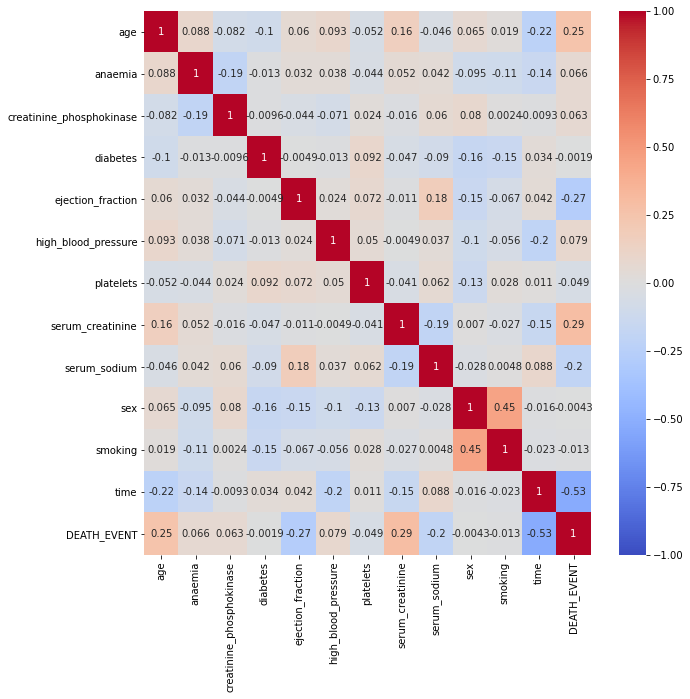

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(heart_data.corr(), vmin=-1, cmap='coolwarm', annot=True);

# **Data Modeling**

**Train Test Split**

In [32]:
Features = ['time','ejection_fraction','serum_creatinine']
x = heart_data[Features]
y = heart_data["DEATH_EVENT"]
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [33]:
accuracy_list = []

**Logistic Regression**

In [34]:
# logistic regression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg_pred = log_reg.predict(x_test)
log_reg_acc = accuracy_score(y_test, log_reg_pred)
accuracy_list.append(100*log_reg_acc)

In [35]:
print("Accuracy of Logistic Regression is : ", "{:.2f}%".format(100* log_reg_acc))

Accuracy of Logistic Regression is :  90.00%


<Figure size 432x288 with 0 Axes>

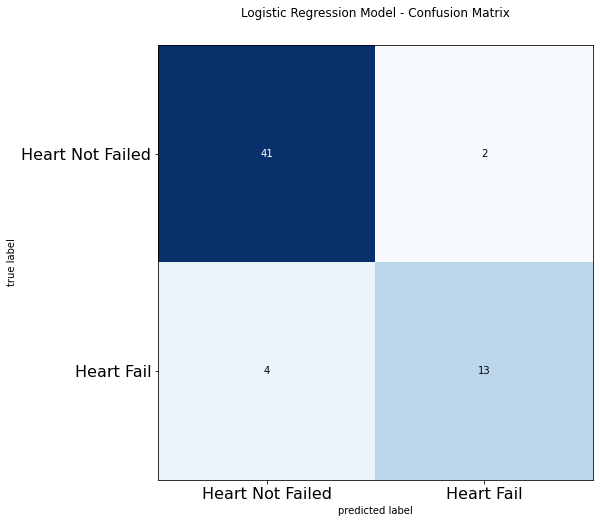

In [36]:
cm = confusion_matrix(y_test, log_reg_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

**Support Vector**

In [37]:
# svc

sv_clf = SVC()
sv_clf.fit(x_train, y_train)
sv_clf_pred = sv_clf.predict(x_test)
sv_clf_acc = accuracy_score(y_test, sv_clf_pred)
accuracy_list.append(100* sv_clf_acc)

In [38]:
print("Accuracy of SVC is : ", "{:.2f}%".format(100* sv_clf_acc))

Accuracy of SVC is :  90.00%


<Figure size 432x288 with 0 Axes>

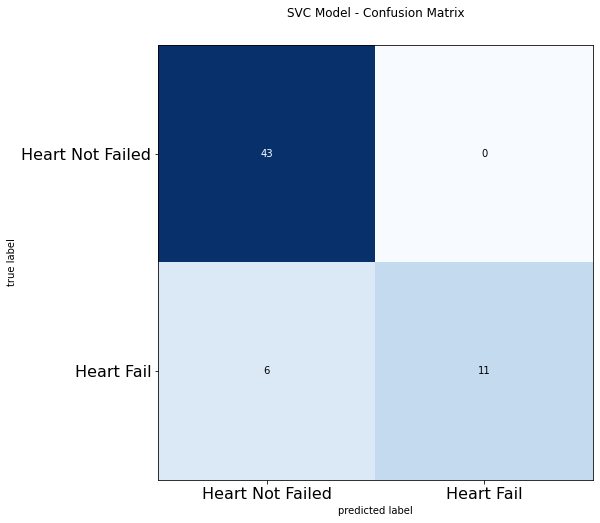

In [39]:
cm = confusion_matrix(y_test, sv_clf_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("SVC Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

**K Neighbors Classifier**

In [40]:
# K Neighbors Classifier

kn_clf = KNeighborsClassifier(n_neighbors=6)
kn_clf.fit(x_train, y_train)
kn_pred = kn_clf.predict(x_test)
kn_acc = accuracy_score(y_test, kn_pred)
accuracy_list.append(100*kn_acc)

In [41]:
print("Accuracy of K Neighbors Classifier is : ", "{:.2f}%".format(100* kn_acc))

Accuracy of K Neighbors Classifier is :  91.67%


<Figure size 432x288 with 0 Axes>

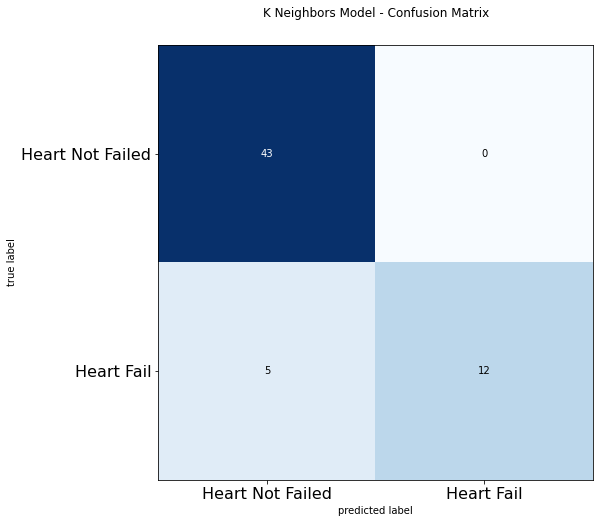

In [42]:
cm = confusion_matrix(y_test, kn_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("K Neighbors Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

**Decision Tree Classifier**

In [43]:
# Decision Tree Classifier

dt_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0, criterion='entropy')
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_test)
dt_acc = accuracy_score(y_test, dt_pred)
accuracy_list.append(100*dt_acc)

In [44]:
print("Accuracy of Decision Tree Classifier is : ", "{:.2f}%".format(100* dt_acc))

Accuracy of Decision Tree Classifier is :  90.00%


<Figure size 432x288 with 0 Axes>

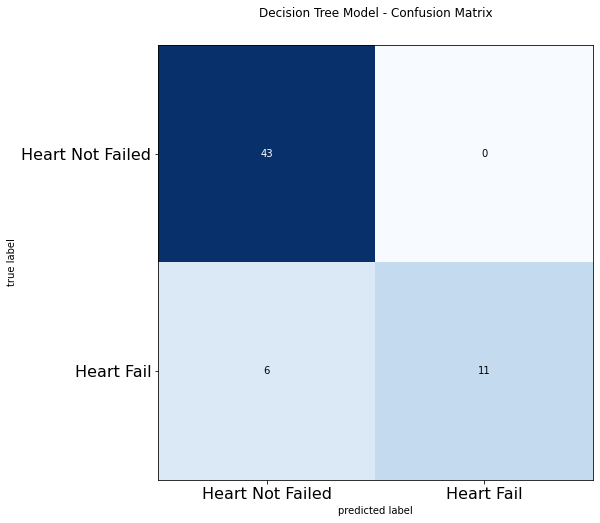

In [45]:
cm = confusion_matrix(y_test, dt_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision Tree Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

**Random Forest Classifier**

In [46]:
# RandomForestClassifier

r_clf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=1)
r_clf.fit(x_train, y_train)
r_pred = r_clf.predict(x_test)
r_acc = accuracy_score(y_test, r_pred)
accuracy_list.append(100*r_acc)

In [47]:
print("Accuracy of Random Forest Classifier is : ", "{:.2f}%".format(100* r_acc))

Accuracy of Random Forest Classifier is :  90.00%


<Figure size 432x288 with 0 Axes>

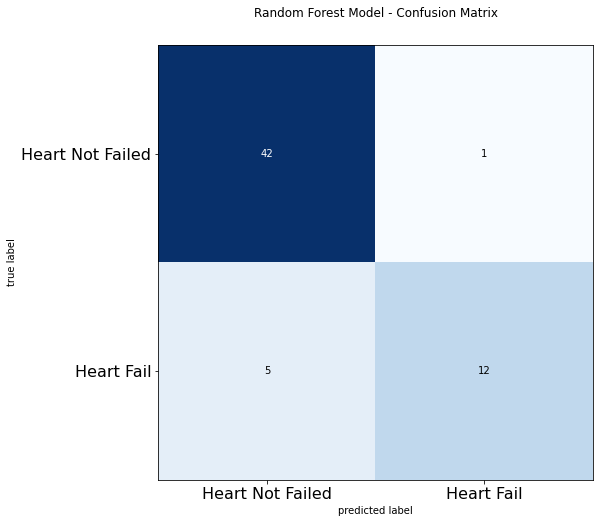

In [48]:
cm = confusion_matrix(y_test, r_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Random Forest Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

**xgbrf classifier**

In [49]:
# xgbrf classifier

xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=1)
xgb_clf.fit(x_train,y_train)
xgb_pred = xgb_clf.predict(x_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
accuracy_list.append(100*xgb_acc)

In [50]:
print("Accuracy of XGBRFClassifier is : ", "{:.2f}%".format(100* xgb_acc))

Accuracy of XGBRFClassifier is :  93.33%


<Figure size 432x288 with 0 Axes>

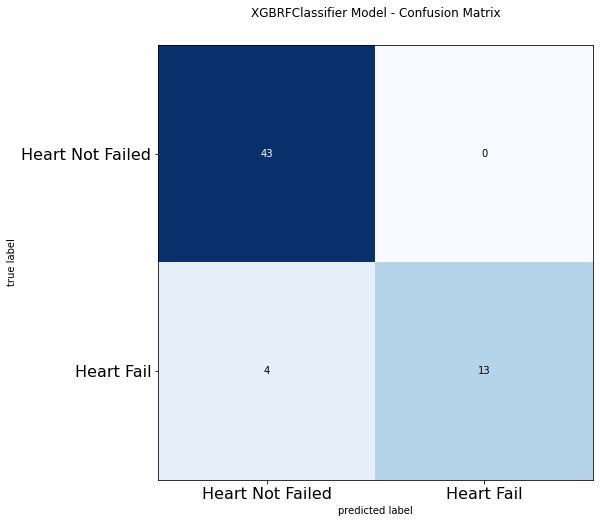

In [51]:
cm = confusion_matrix(y_test, xgb_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("XGBRFClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [52]:
model_list = ['Logistic Regression', 'SVC','KNearestNeighbours', 'DecisionTree', 'RandomForest',
               'XGBRF']

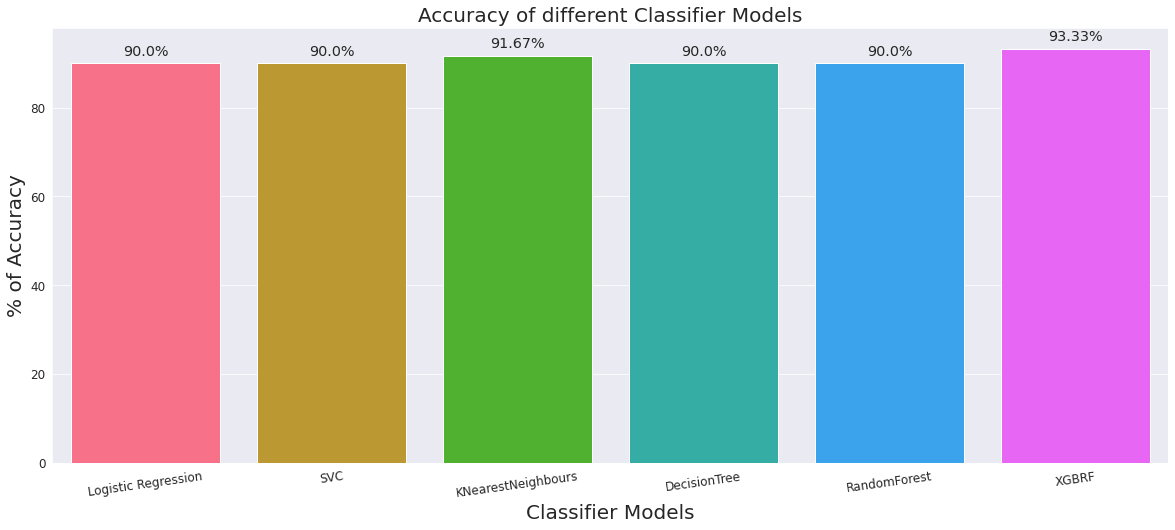

In [53]:
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=accuracy_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()